# Data loading and inspection 

In [326]:
#Importing the necessary libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import FreqDist

#modelling libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

#imbalance libraries 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Davey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Davey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Davey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [327]:

# Import necessary classes from the init module
from __init__ import Explore, Clean

In [328]:
#load the data and print first five rows to ensure it loaded correctly
data = pd.read_csv('data.csv', encoding='ISO-8859-1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [329]:
#create instance of explore class
explore_df = Explore(data)

In [330]:
# Check the shape of the data
explore_df.shape()

----------------Shape of the Dataset---------------- 

(9093, 3)


In [331]:
#Check the columns of the data
explore_df.features()

----------------Features in the Dataset---------------- 

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')


In [332]:
#Check the summary statistics of the data
explore_df.stats()

----------------Summary Statistics of the Features---------------- 

                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


In [333]:
#Check the basic information of the data
explore_df.info()

----------------Dataset Overall Information---------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None


In [334]:
#Renaming the columns
def rename_columns(df):
    df.columns=['tweet_text',  'recipient', 'emotion']
    return df
data = rename_columns(data)
data.head()

,tweet_text,recipient,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [335]:
# Initialize the cleaning class and call the method for displaying missing values
clean_df = Clean(data)
clean_df.missing_duplicated()



 Duplicated Rows:

- Total duplicated rows: 22 
 



,Missing Values,Percentage(%)
recipient,5802,63.807324
tweet_text,1,0.010997
emotion,0,0.000000


In [336]:
# Drop the missing record in the tweet_text column
data = data.dropna(subset=['tweet_text'])
#Check to ensure the missing record is dropped
data.isnull().sum()

tweet_text       0
recipient     5801
emotion          0
dtype: int64

In [337]:
# Fill missing values in the 'recipient' column with 'No brand'
data['recipient'].fillna('No brand', inplace=True)

c:\Users\Davey\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [338]:
#Drop the duplicate rows
clean_df.remove_duplicated_rows()

'The dataset now has 0 duplicate rows'

We'll also focus on cleaning the emotion column by simplifying the emotion labels by converting them:

'Positive Emotion'->'Positive'

'Negative Emotion'->'Negative'

'No emotion toward brand or product' and 'I can't tell'->'Neutral

This standardization will make sentiment classification easier and more consistent for analysis and modeling.

In [339]:

# Change emotions to 'Positive', 'Negative', and 'Neutral'
data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
data.loc[data['emotion'] == 'Positive emotion', 'emotion'] = 'Positive'
data.loc[data['emotion'] == 'Negative emotion', 'emotion'] = 'Negative'
data.loc[data['emotion'] == "I can't tell", 'emotion'] = 'Neutral'

data.head()

c:\Users\Davey\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-339-aa62197acfba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral'
<ipython-input-339-aa62197acfba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[d

,tweet_text,recipient,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


### Feature engineering 

In [340]:
data['brand'] = data['recipient'].map({'Other Apple product or service': 'Apple', 
                                           'Android': 'Google',
                                           'Android App': 'Google',
                                           'Other Google product or service ': 'Google',
                                           'iPhone': 'Apple', 
                                           'Google':'Google',
                                           'iPad or iPhone App': 'Apple',
                                           'Apple':'Apple',
                                           'iPad':'Apple',
                                           'No brand': 'none'})

data['brand'].value_counts()

<ipython-input-340-bd7854d1d439>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand'] = data['recipient'].map({'Other Apple product or service': 'Apple',


none      5801
Apple     2409
Google     589
Name: brand, dtype: int64

# Exploratory data analysis (EDA)

#### Univariate analysis

Neutral     60.976683
Positive    32.754070
Negative     6.269248
Name: emotion, dtype: float64


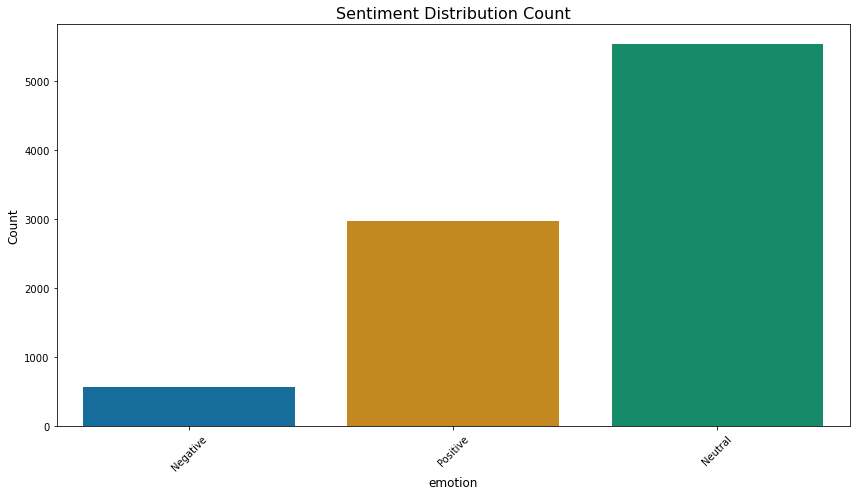

In [341]:
#checking the distribution of sentiments
percentage = data['emotion'].value_counts(normalize=True)
print(percentage * 100)

#Count plot of the 'emotion' column
plt.figure(figsize=(12, 7))
sns.countplot(x='emotion', data=data, palette='colorblind')
plt.title('Sentiment Distribution Count', fontsize=16)
plt.xlabel('emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels if they’re long
plt.tight_layout()
plt.show()

none      65.927946
Apple     27.378111
Google     6.693942
Name: brand, dtype: float64


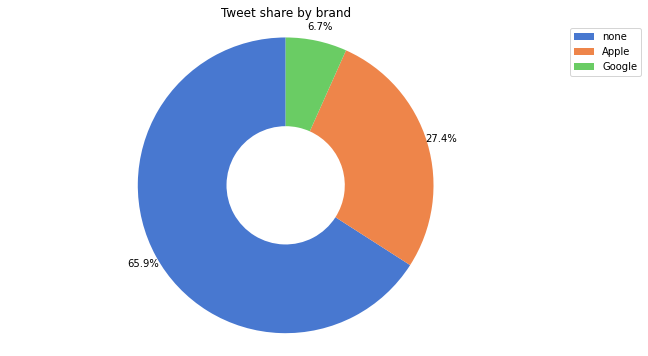

In [342]:
#pie chart to visualize Tweet share by brand
brand_share = data['brand'].value_counts(normalize=True)
print(brand_share * 100)

#Visualizing using pie chart
plt.figure(figsize=(10, 6))
plt.pie(brand_share.values, autopct='%1.1f%%', pctdistance=1.1, startangle=90, colors=sns.color_palette('muted'), wedgeprops={'width': 0.6})
plt.title('Tweet share by brand')
plt.axis('equal')
plt.legend(labels=brand_share.index, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


<ipython-input-343-cbf37f68eade>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_length'] = data['tweet_text'].apply(lambda x: len(str(x).split()))


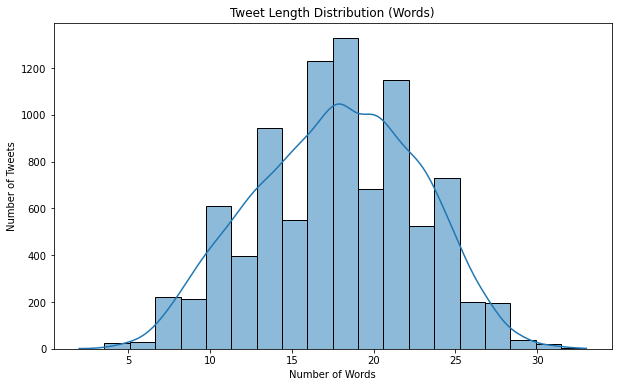

In [343]:
# Count number of words in each tweet (not characters)
data['tweet_length'] = data['tweet_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['tweet_length'], bins=20, kde=True)
plt.title('Tweet Length Distribution (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.show()

### Bivariate analysis

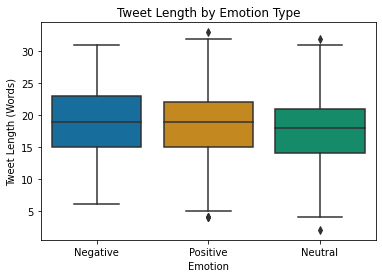

In [344]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='emotion', y='tweet_length', palette='colorblind')
plt.title('Tweet Length by Emotion Type')
plt.xlabel('Emotion')
plt.ylabel('Tweet Length (Words)')
plt.show()


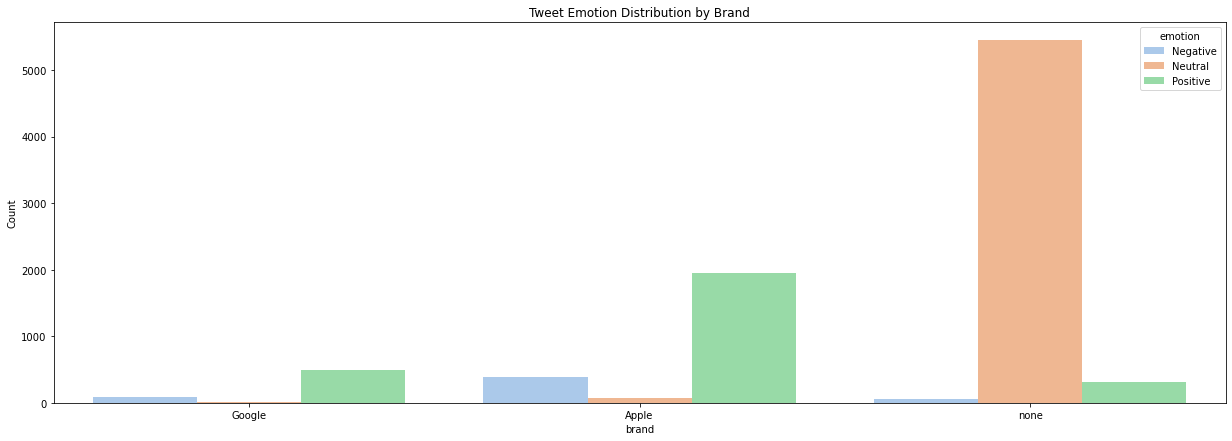

In [345]:

#Which brand is getting more positive or negative tweets?
brands = data.groupby(['brand','emotion']).size().reset_index(name='count')

#Calculate the ascending order of brands based on tweet count
ascending_order = brands.groupby('brand')['count'].sum().sort_values().index

plt.figure(figsize=(21,7))
sns.barplot(x='brand', y='count', hue='emotion', data=brands, palette='pastel', order=ascending_order)
plt.xlabel('brand')
plt.ylabel('Count')
plt.title('Tweet Emotion Distribution by Brand')
plt.show()

In [346]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def generate_text_features(self, df, text_column):
        """
        Adds character count, word count, and sentence count columns.
        """
        df.loc[:, 'char_count'] = df[text_column].astype(str).apply(len)
        df.loc[:, 'word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))
        df.loc[:, 'sentence_count'] = df[text_column].astype(str).apply(lambda x: x.count('.') + 1)
        return df

    def clean_text(self, text):
        """
        Cleans text: lowercase, remove URLs, hashtags, emojis, punctuation, numbers, and extra spaces.
        """
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        text = re.sub(r"#\w+", '', text)

        # Remove emojis
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags
            u"\U00002700-\U000027BF"  # Dingbats
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE
        )
        text = emoji_pattern.sub(r'', text)

        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize(self, text):
        """
        Tokenizes and removes stopwords.
        """
        tokens = word_tokenize(text)
        return [t for t in tokens if t not in self.stop_words]

    def lemmatize(self, tokens):
        """
        Lemmatizes a list of tokens.
        """
        return [self.lemmatizer.lemmatize(t) for t in tokens]

    def preprocess(self, df, text_column):
        """
        Full preprocessing:
        - Feature engineering
        - Text cleaning
        - Tokenization
        - Lemmatization
        - Save cleaned text, tokens, lemmatized tokens, and document string (from tokens)
        """
        df = df.copy()  # Avoid SettingWithCopyWarning

        df = self.generate_text_features(df, text_column)
        df.loc[:, 'cleaned_text'] = df[text_column].astype(str).apply(self.clean_text)
        df.loc[:, 'tokenized_text'] = df['cleaned_text'].apply(self.tokenize)
        df.loc[:, 'lemmatized_text'] = df['tokenized_text'].apply(self.lemmatize)
        df.loc[:, 'document'] = df['tokenized_text'].apply(lambda x: ' '.join(x))

        return df

In [347]:
preprocessor = TextPreprocessor()
data = preprocessor.preprocess(data, 'tweet_text')

In [348]:
data.head(3)

,tweet_text,recipient,emotion,brand,tweet_length,char_count,word_count,sentence_count,cleaned_text,tokenized_text,lemmatized_text,document
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,23,127,23,5,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hrs, tweeting, dead, need,...","[wesley, g, iphone, hr, tweeting, dead, need, ...",wesley g iphone hrs tweeting dead need upgrade...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,22,139,22,2,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, fludapp, awesome, ipadiphone,...","[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,15,79,15,3,swonderlin can not wait for also they should s...,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]",swonderlin wait also sale


In [349]:
le = LabelEncoder()

data['emotion_code'] = le.fit_transform(data['emotion'])

In [350]:
data[['emotion', 'emotion_code']]

,emotion,emotion_code
0,Negative,0
1,Positive,2
2,Positive,2
3,Negative,0
4,Positive,2
...,...,...
9088,Positive,2
9089,Neutral,1
9090,Neutral,1
9091,Neutral,1


In [351]:
binary_data = data.copy()
binary_data.head(10)

,tweet_text,recipient,emotion,brand,tweet_length,char_count,word_count,sentence_count,cleaned_text,tokenized_text,lemmatized_text,document,emotion_code
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,23,127,23,5,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hrs, tweeting, dead, need,...","[wesley, g, iphone, hr, tweeting, dead, need, ...",wesley g iphone hrs tweeting dead need upgrade...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,22,139,22,2,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, fludapp, awesome, ipadiphone,...","[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,15,79,15,3,swonderlin can not wait for also they should s...,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]",swonderlin wait also sale,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,15,82,15,2,sxsw i hope this years festival isnt as crashy...,"[sxsw, hope, years, festival, isnt, crashy, ye...","[sxsw, hope, year, festival, isnt, crashy, yea...",sxsw hope years festival isnt crashy years iph...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,17,131,17,1,sxtxstate great stuff on fri marissa mayer goo...,"[sxtxstate, great, stuff, fri, marissa, mayer,...","[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...,2
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No brand,Neutral,none,18,140,18,2,teachntech new ipad apps for and communication...,"[teachntech, new, ipad, apps, communication, s...","[teachntech, new, ipad, apps, communication, s...",teachntech new ipad apps communication showcas...,1
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive,Google,28,138,28,1,is just starting is around the corner and is o...,"[starting, around, corner, hop, skip, jump, go...","[starting, around, corner, hop, skip, jump, go...",starting around corner hop skip jump good time...,2
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive,Apple,17,129,17,2,beautifully smart and simple idea rt madebyman...,"[beautifully, smart, simple, idea, rt, madebym...","[beautifully, smart, simple, idea, rt, madebym...",beautifully smart simple idea rt madebymany th...,2
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive,Apple,16,88,16,1,counting down the days to plus strong canadian...,"[counting, days, plus, strong, canadian, dolla...","[counting, day, plus, strong, canadian, dollar...",counting days plus strong canadian dollar mean...,2
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive,Google,21,118,21,3,excited to meet the samsungmobileus at so i ca...,"[excited, meet, samsungmobileus, show, sprint,...","[excited, meet, samsungmobileus, show, sprint,...",excited meet samsungmobileus show sprint galax...,2


In [352]:
binary_data.drop(binary_data[binary_data['emotion_code'] == 1].index, inplace=True)
binary_data.head(10)

,tweet_text,recipient,emotion,brand,tweet_length,char_count,word_count,sentence_count,cleaned_text,tokenized_text,lemmatized_text,document,emotion_code
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,Apple,23,127,23,5,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hrs, tweeting, dead, need,...","[wesley, g, iphone, hr, tweeting, dead, need, ...",wesley g iphone hrs tweeting dead need upgrade...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,Apple,22,139,22,2,jessedee know about fludapp awesome ipadiphone...,"[jessedee, know, fludapp, awesome, ipadiphone,...","[jessedee, know, fludapp, awesome, ipadiphone,...",jessedee know fludapp awesome ipadiphone app y...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,Apple,15,79,15,3,swonderlin can not wait for also they should s...,"[swonderlin, wait, also, sale]","[swonderlin, wait, also, sale]",swonderlin wait also sale,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,Apple,15,82,15,2,sxsw i hope this years festival isnt as crashy...,"[sxsw, hope, years, festival, isnt, crashy, ye...","[sxsw, hope, year, festival, isnt, crashy, yea...",sxsw hope years festival isnt crashy years iph...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,Google,17,131,17,1,sxtxstate great stuff on fri marissa mayer goo...,"[sxtxstate, great, stuff, fri, marissa, mayer,...","[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...,2
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive,Google,28,138,28,1,is just starting is around the corner and is o...,"[starting, around, corner, hop, skip, jump, go...","[starting, around, corner, hop, skip, jump, go...",starting around corner hop skip jump good time...,2
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive,Apple,17,129,17,2,beautifully smart and simple idea rt madebyman...,"[beautifully, smart, simple, idea, rt, madebym...","[beautifully, smart, simple, idea, rt, madebym...",beautifully smart simple idea rt madebymany th...,2
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive,Apple,16,88,16,1,counting down the days to plus strong canadian...,"[counting, days, plus, strong, canadian, dolla...","[counting, day, plus, strong, canadian, dollar...",counting days plus strong canadian dollar mean...,2
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive,Google,21,118,21,3,excited to meet the samsungmobileus at so i ca...,"[excited, meet, samsungmobileus, show, sprint,...","[excited, meet, samsungmobileus, show, sprint,...",excited meet samsungmobileus show sprint galax...,2
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,Android App,Positive,Google,19,129,19,3,find amp start impromptu parties at with hurri...,"[find, amp, start, impromptu, parties, hurrica...","[find, amp, start, impromptu, party, hurricane...",find amp start impromptu parties hurricanepart...,2


In [353]:
binary_data['emotion_code'].value_counts()

2    2978
0     570
Name: emotion_code, dtype: int64

In [354]:
# split data to train and test sets

X = binary_data['document']
y = binary_data['emotion_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [355]:
# vectorize

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [356]:
logreg = LogisticRegression()

logreg.fit(X_train_vec, y_train)

LogisticRegression()

In [357]:
y_pred = logreg.predict(X_test_vec)
y_train_pred = logreg.predict(X_train_vec)

print("Train accuracy:", accuracy_score(y_train, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))

Train accuracy: 0.971815107102593
Test accuracy: 0.8804960541149943


In [358]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.35      0.48       137
           2       0.89      0.98      0.93       750

    accuracy                           0.88       887
   macro avg       0.82      0.66      0.70       887
weighted avg       0.87      0.88      0.86       887



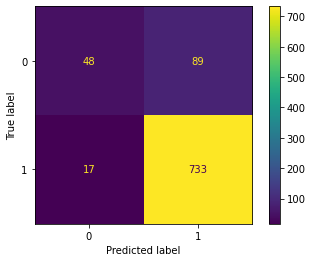

In [359]:
#plot a confusion matrix
log_matrix = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = log_matrix)
cm_display.plot()
plt.show()

From the classification report, the model performs well for the majority class(positive) but poorly on the other class. This is because of class imbalance.

We'll try fitting a decision tree while accounting for the class imbalance to see if there will be better peerformance

In [360]:
weighted_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
weighted_tree.fit(X_train_vec, y_train)


y_train_pred = weighted_tree.predict(X_train_vec)
y_pred = weighted_tree.predict(X_test_vec)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.7948139797068771

 Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.53      0.45       137
           2       0.91      0.84      0.87       750

    accuracy                           0.79       887
   macro avg       0.65      0.69      0.66       887
weighted avg       0.83      0.79      0.81       887



The tree performs worse than the logistic regression model. Let's try fitting again without accounting for the imbalance

In [361]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_vec, y_train)

DecisionTreeClassifier(random_state=42)

In [362]:
# Evaluation 
y_train_pred = tree.predict(X_train_vec)
y_pred = tree.predict(X_test_vec)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.8680947012401353

 Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.36      0.46       137
           2       0.89      0.96      0.92       750

    accuracy                           0.87       887
   macro avg       0.76      0.66      0.69       887
weighted avg       0.85      0.87      0.85       887



The tree performs a bit better without accounting for class imbalance

However the accuracies are not satisfactory so we'll try tuning to reduce overfitting

In [363]:
param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy', 'log_loss']  
}


grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)


grid_search.fit(X_train_vec, y_train)


print("Best Parameters:", grid_search.best_params_)

best_tree = grid_search.best_estimator_

y_train_pred = best_tree.predict(X_train_vec)
y_pred = best_tree.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"\n Test Accuracy: {accuracy_score(y_test, y_pred)}")

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}

 Train Accuracy: 0.8726042841037204

 Test Accuracy: 0.8635851183765502


These are reasonable accuracies

So far this tuned tree and logistic regression are the best models

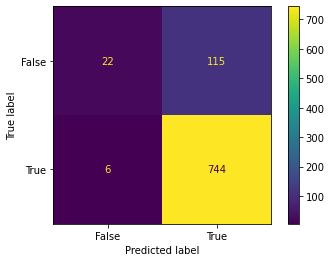

In [364]:
tree_matrix = confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = tree_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Tuning reduces overfitting. However there are many false positives

Let's try another model

In [365]:
forest = RandomForestClassifier(random_state=42)

forest.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [366]:
y_train_pred = forest.predict(X_train_vec)
y_pred = forest.predict(X_test_vec)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Train Accuracy: 1.0
Test Accuracy: 0.8804960541149943


The random forest is overfitting the data 

Let's try tuning it

In [367]:
param_grid = {
    'n_estimators': [50, 100],         # Number of trees
    'max_depth': [None, 5, 10],            # Depth of each tree
    'min_samples_split': [2, 5],        # Min samples to split a node
    'min_samples_leaf': [1, 2],          # Min samples at a leaf node
    'criterion': ['gini', 'entropy', 'log_loss'],        # Splitting criteria
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

grid.fit(X_train_vec, y_train)

print("Best Parameters:", grid.best_params_)

best_rf = grid.best_estimator_

y_train_pred = best_rf.predict(X_train_vec)
y_pred = best_rf.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

 Train Accuracy: 1.0
Test Accuracy: 0.8804960541149943


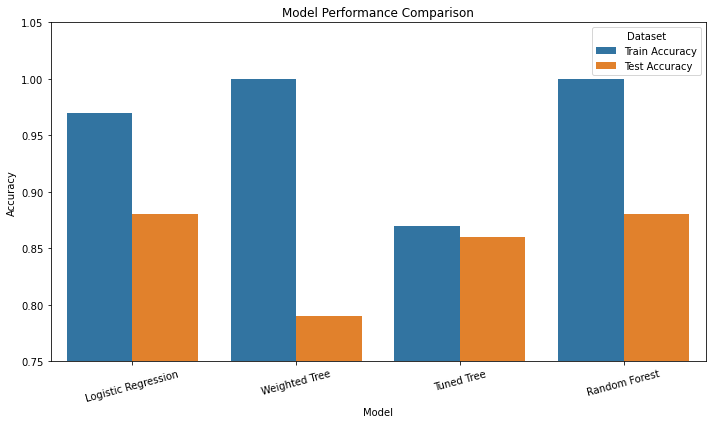

In [368]:
# Sample performance data
models = ['Logistic Regression', 'Weighted Tree', 'Tuned Tree', 'Random Forest']
train_accuracy = [0.97, 1.00, 0.87, 1.00]
test_accuracy = [0.88, 0.79, 0.86, 0.88]

# Create a DataFrame
df = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Accuracy', hue='Dataset')
plt.title('Model Performance Comparison')
plt.ylim(0.75, 1.05)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [369]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)

print("Resampled class distribution:", pd.Series(y_train_resampled).value_counts())

Resampled class distribution: 2    2228
0    2228
Name: emotion_code, dtype: int64


In [370]:
logreg.fit(X_train_resampled, y_train_resampled)

y_pred = logreg.predict(X_test_vec)
y_train_pred = logreg.predict(X_train_resampled)

print("Train accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("Test accuracy:", accuracy_score(y_test, y_pred))


Train accuracy: 0.973967684021544
Test accuracy: 0.8072153325817362


In [371]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.64      0.50       137
           2       0.93      0.84      0.88       750

    accuracy                           0.81       887
   macro avg       0.67      0.74      0.69       887
weighted avg       0.85      0.81      0.82       887



After resampling the data, the logistic regression performs a bit better for the minority class

The accuracies are however worse than the first logistic regression model

Let's try our tuned tree on the resampled data

In [372]:
param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy', 'log_loss']  
}


grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)


grid_search.fit(X_train_resampled, y_train_resampled)


print("Best Parameters:", grid_search.best_params_)

best_tree = grid_search.best_estimator_

y_train_pred = best_tree.predict(X_train_resampled)
y_pred = best_tree.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train_resampled, y_train_pred)}")
print(f"\n Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

 Train Accuracy: 0.9755385996409336

 Test Accuracy: 0.7406989853438557

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.51      0.38       137
           2       0.90      0.78      0.84       750

    accuracy                           0.74       887
   macro avg       0.60      0.65      0.61       887
weighted avg       0.81      0.74      0.77       887



The tuned tree now overfits the data hence the other tuned tree is better

Let's try one final model, one which we haven't tried out so far; an xgboost classifier

In [373]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

y_train_pred = xgb.predict(X_train_resampled)
y_pred = xgb.predict(X_test_vec)

print(f"\n Train Accuracy: {accuracy_score(y_train_resampled, y_train_pred)}")
print(f"\n Test Accuracy: {accuracy_score(y_test, y_pred)}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


 Train Accuracy: 0.9499551166965888

 Test Accuracy: 0.8568207440811725

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.22      0.32       137
           2       0.87      0.97      0.92       750

    accuracy                           0.86       887
   macro avg       0.74      0.60      0.62       887
weighted avg       0.83      0.86      0.83       887



The accuracies are good but may indicate slight overfitting because of the differences.
It also does not perform well on the minority class